In [ ]:
pip install yfinance

In [2]:
from cvxpy_portfolio_optimizer.objective_function import (
    CVaRObjectiveFunction,
    VarianceObjectiveFunction,
    ExpectedReturnsObjectiveFunction,
)
from cvxpy_portfolio_optimizer.constraint_function import SumToOneConstraint, NoShortSellConstraint
from cvxpy_portfolio_optimizer.portfolio_optimization_problem import PortfolioOptimizationProblem
import yfinance as yf
import cvxpy as cp

In [3]:
tickers = ["TSLA", "MSFT", "IBM", "GOOG", "AAPL", "AMZN", "ADBE"]
rets = (
    yf.download(tickers, period="1y")["Adj Close"].loc[:, tickers].pct_change().iloc[1:, :].ffill()
)
rets

[*********************100%%**********************]  7 of 7 completed


Ticker,TSLA,MSFT,IBM,GOOG,AAPL,AMZN,ADBE
Date,,,,,,,
2023-05-23,-0.016413,-0.018432,0.005333,-0.020497,-0.015155,-0.000174,-0.004381
2023-05-24,-0.015449,-0.004473,-0.019504,-0.013383,0.001632,0.015306,-0.012580
2023-05-25,0.008584,0.038458,0.008593,0.022279,0.006692,-0.014989,0.071905
2023-05-26,0.047162,0.021386,0.016803,0.008685,0.014105,0.044435,0.059506
2023-05-30,0.041363,-0.005047,0.004578,-0.006298,0.010660,0.012905,0.004381
...,...,...,...,...,...,...,...
2024-05-14,0.032928,0.006865,-0.001194,0.006027,0.006173,0.002680,-0.014821
2024-05-15,-0.020051,0.017484,0.005378,0.011342,0.012218,-0.005773,0.019750
2024-05-16,0.004885,-0.004940,0.004220,0.008914,0.000632,-0.012689,-0.005089


In the following portfolio optimization problem we will:
- Minimize CVaR at 95% confidence level
- Minimize Variance
- Maximize Expected Retruns

In [4]:
pop = PortfolioOptimizationProblem(
    returns=rets,
    objective_functions=[
        CVaRObjectiveFunction(confidence_level=0.95, weight=1.0),
        VarianceObjectiveFunction(weight=1.0),
        ExpectedReturnsObjectiveFunction(weight=0.3),
    ],
    constraint_functions=[
        SumToOneConstraint(),
        NoShortSellConstraint(),
    ],
)

In [5]:
ptf = pop.solve(solver=cp.CLARABEL)

In [6]:
ptf.weights

TSLA    0.000000
MSFT    0.000000
IBM     0.473424
GOOG    0.064285
AAPL    0.000000
AMZN    0.462290
ADBE    0.000000
dtype: float64

In [7]:
ptf.objectives

[ObjectiveModel(name=<ObjectiveFunctionName.CVAR: 'CVaR'>, function=Minimize(Expression(AFFINE, UNKNOWN, (1,)))),
 ObjectiveModel(name=<ObjectiveFunctionName.VARIANCE: 'VARIANCE'>, function=Minimize(Expression(CONVEX, NONNEGATIVE, ()))),
 ObjectiveModel(name=<ObjectiveFunctionName.EXPECTED_RETURNS: 'EXPECTED_RETURNS'>, function=Minimize(Expression(AFFINE, UNKNOWN, ())))]

In [8]:
{obj.name: obj.function.value for obj in ptf.objectives}

{<ObjectiveFunctionName.CVAR: 'CVaR'>: 0.024559334254136513,
 <ObjectiveFunctionName.VARIANCE: 'VARIANCE'>: 0.03395050090264381,
 <ObjectiveFunctionName.EXPECTED_RETURNS: 'EXPECTED_RETURNS'>: -0.12995469292210624}

In [9]:
ptf.get_total_objective_value()

-0.07144485776532591

<Axes: xlabel='Date'>

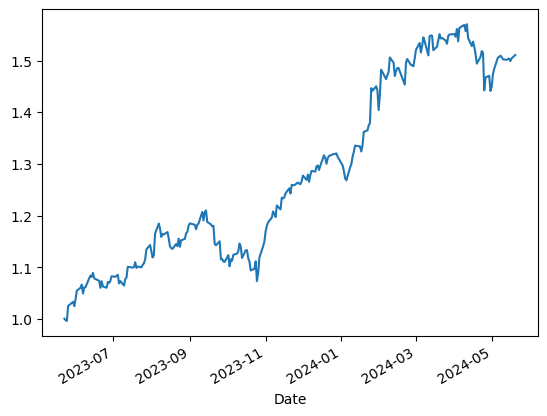

In [10]:
ptf.portfolio_timeseries().plot()